In [23]:
import pandas as pd
import json
import requests
import copy
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn import model_selection, preprocessing, metrics
import seaborn as sns
import estateFunction

In [24]:
###경제상황을 반영해주기 위해 각종 지수들을 넣어줌.

###공동주택 실거래 가격지수 아파트 
apartIndex=pd.read_csv("indexData/apartIndex.csv",encoding="cp949")
apartIndex=list((apartIndex.iloc[10].reset_index())[10])[2:]
###경기종합 선행 지수
economicIndex=pd.read_csv("indexData/economicPredictionIndex.csv",encoding="cp949")
economicIndex=list((economicIndex.iloc[10].reset_index()[10])[1:])
###생산자 물가 지수
produceIndex=pd.read_csv("indexData/produceIndex.csv",encoding="cp949")
produceIndex=list((produceIndex.iloc[10].reset_index()[10])[1:])
###소비자 물가 지수
spendIndex=pd.read_csv("indexData/spendIndex.csv",encoding="cp949")
spendIndex=list((spendIndex.iloc[10].reset_index()[10])[1:])

In [25]:
###2018/12데이터를 예측하므로 2018/11까지 있어야됨
###2018/12데이터에는 2018/11데이터넣음
###2010/01데이터에는 2009/12데이터넣음
def makeApartIndex(x):
    index=(x-201001)//100*12+(x-201001)%100
    return apartIndex[index]
def makeEconomicIndex(x):
    index=(x-201001)//100*12+(x-201001)%100
    return economicIndex[index]
def makeSpendIndex(x):
    index=(x-201001)//100*12+(x-201001)%100
    return spendIndex[index]
def makeProduceIndex(x):
    index=(x-201001)//100*12+(x-201001)%100
    return produceIndex[index]

In [26]:
kfoldData=pd.read_csv("dataAfterPreprocess/finaltrain")  
kfoldTarget=kfoldData['거래금액(만원)']
#target값 삭제해주고 나머지 변수들은 훈련에 사용될 수 없음
del kfoldData['거래금액(만원)']
del kfoldData['시군구']
del kfoldData['번지']
del kfoldData['본번']
del kfoldData['부번']
###object에서 category로 바꾸어주어야함
kfoldData['단지명']=kfoldData['단지명'].astype('category')
kfoldData['도로명']=kfoldData['도로명'].astype('category')
kfoldData['big']=kfoldData['big'].astype('category')
kfoldData['small']=kfoldData['small'].astype('category')

In [27]:
kfoldData['apartIndex']=kfoldData['계약년월'].apply(makeApartIndex).astype('float')
kfoldData['economicIndex']=kfoldData['계약년월'].apply(makeEconomicIndex).astype('float')
kfoldData['spendIndex']=kfoldData['계약년월'].apply(makeSpendIndex).astype('float')
kfoldData['produceIndex']=kfoldData['계약년월'].apply(makeProduceIndex).astype('float')

In [28]:
kfoldTest=pd.read_csv("dataAfterPreprocess/finaltest")
testTarget=kfoldTest["거래금액(만원)"]/kfoldTest['전용면적(㎡)']
#target값 삭제해주고 나머지 변수들은 훈련에 사용될 수 없음
del kfoldTest['거래금액(만원)']
del kfoldTest['시군구']
del kfoldTest['번지']
del kfoldTest['본번']
del kfoldTest['부번']
del kfoldTest['공시가격']
del kfoldTest['공시가격(만원)']
###object에서 category로 바꾸어주어야함
kfoldTest['단지명']=kfoldTest['단지명'].astype('category')
kfoldTest['도로명']=kfoldTest['도로명'].astype('category')
kfoldTest['big']=kfoldTest['big'].astype('category')
kfoldTest['small']=kfoldTest['small'].astype('category')

In [29]:
kfoldTest['apartIndex']=kfoldTest['계약년월'].apply(makeApartIndex).astype('float')
kfoldTest['economicIndex']=kfoldTest['계약년월'].apply(makeEconomicIndex).astype('float')
kfoldTest['spendIndex']=kfoldTest['계약년월'].apply(makeSpendIndex).astype('float')
kfoldTest['produceIndex']=kfoldTest['계약년월'].apply(makeProduceIndex).astype('float')

In [32]:
kfoldData.columns=['Apart name','USM','Sold date','Storey','Build year','Street name','latitude','longitude','District','dong',
                   'Sold month','Apart index','Leading index','Consumer index', 'Producer index']
kfoldTest.columns=['Apart name','USM','Sold date','Storey','Build year','Street name','latitude','longitude','District','dong',
                   'Sold month','Apart index','Leading index','Consumer index', 'Producer index']
###ppsm으로 고쳐줘야 되므로
kfoldTarget=kfoldTarget/kfoldData['USM']

In [33]:
len(kfoldData),len(kfoldTarget),len(kfoldTest),len(testTarget)

(554312, 554312, 1393, 1393)

In [34]:
SST=sum((testTarget-np.mean(testTarget))**2)

In [35]:
###big제외하고 원핫인코딩하기에는 너무 많다.
kfoldDataWithBig=copy.deepcopy(kfoldData)
kfoldTestWithBig=copy.deepcopy(kfoldTest)
del kfoldDataWithBig['Apart name']
del kfoldDataWithBig['Street name']
del kfoldDataWithBig['dong']
del kfoldTestWithBig['Apart name']
del kfoldTestWithBig['Street name']
del kfoldTestWithBig['dong']

In [36]:
cat_features = ['District'] 

for column in cat_features:
    temp = pd.get_dummies(pd.Series(kfoldDataWithBig[column])) 
    kfoldDataWithBig = pd.concat([kfoldDataWithBig,temp],axis=1) 
    kfoldDataWithBig = kfoldDataWithBig.drop([column],axis=1) 

for column in cat_features: 
    temp = pd.get_dummies(pd.Series(kfoldTestWithBig[column])) 
    kfoldTestWithBig = pd.concat([kfoldTestWithBig,temp],axis=1) 
    kfoldTestWithBig = kfoldTestWithBig.drop([column],axis=1)

In [37]:
#OLS
from sklearn.linear_model import LinearRegression
reg=LinearRegression()
reg.fit(kfoldDataWithBig,kfoldTarget)
olsPre=reg.predict(kfoldTestWithBig)
olsOof=reg.predict(kfoldDataWithBig)
reg.intercept_,reg.coef_

(-131192.15449393567,
 array([-1.16479458e+00,  7.77454988e-02,  5.84953234e+00,  1.18272560e+00,
         1.51192143e+03,  4.53427989e+02,  1.01912973e+00,  9.71996600e-01,
         2.50740539e+01, -4.72872807e+01,  1.57624570e+01,  6.09856443e+02,
        -4.78333598e+01, -3.08584535e+02, -3.66521102e+01,  1.40682899e+01,
         5.48852010e+01, -2.48995873e+01, -2.73540415e+01, -3.43446120e+02,
        -3.92116847e+02, -1.92632758e+02,  1.25412681e+02,  1.01796672e+02,
        -1.07887041e+02,  4.99537808e+02,  5.69988991e+01, -2.20765511e+02,
         2.65974723e+02,  1.18365738e+02,  7.92028254e+01,  3.00958412e+02,
        -1.87463938e+02, -3.57760689e+01,  5.11911551e+00, -3.06764890e+02]))

In [38]:
(abs(testTarget-olsPre)/testTarget*100).describe()

count    1393.000000
mean       18.668295
std        16.988034
min         0.014343
25%         6.556310
50%        14.655353
75%        25.470564
max       162.819954
dtype: float64

In [39]:
1-sum((testTarget-olsPre)**2)/SST

0.6481738097326828

In [43]:
###randomforest 단일모델
from sklearn.ensemble import RandomForestRegressor
rfOof = np.zeros(len(kfoldDataWithBig))
rfPre = np.zeros(len(kfoldTestWithBig)) 
folds=KFold(n_splits=5,shuffle=True,random_state=15)

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(kfoldDataWithBig,kfoldTarget)) : 
    print(n_fold)
    trn_x, trn_y = kfoldDataWithBig.iloc[trn_idx], kfoldTarget[trn_idx] 
    val_x, val_y = kfoldDataWithBig.iloc[val_idx], kfoldTarget[val_idx] 
    ranFo=RandomForestRegressor(n_estimators=1500, max_leaf_nodes=15, n_jobs=-1,max_features="sqrt")
    ranFo.fit(trn_x,trn_y)
    
    rfOof[val_idx]=ranFo.predict(val_x)
    rfPre+=ranFo.predict(kfoldTestWithBig)/folds.n_splits

0
1
2
3
4


In [44]:
(abs(testTarget-rfPre)/testTarget*100).describe()

count    1393.000000
mean       20.862939
std        18.788838
min         0.011029
25%         8.016255
50%        16.214169
75%        28.285586
max       149.139104
dtype: float64

In [45]:
1-sum((testTarget-rfPre)**2)/SST

0.6099199986588382

In [ ]:
###xgboost 단일모델 
xgboost.train(params, dtrain, num_boost_round=10, 
              evals=(), obj=None, feval=None, maximize=False, early_stopping_rounds=None, 
              evals_result=None, verbose_eval=True, xgb_model=None, callbacks=None, learning_rates=None)
evals (list of pairs (DMatrix, string)) – List of validation sets for which metrics will evaluated during training. 
Validation metrics will help us track the performance of the model.

In [46]:
###범주형 변수 big만 남겼음
###속도가 빨라짐
print("xgboost") 
xgbOof = np.zeros(len(kfoldDataWithBig))
xgbPre = np.zeros(len(kfoldTestWithBig)) 
folds=KFold(n_splits=5,shuffle=True,random_state=15)
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(kfoldDataWithBig,kfoldTarget)) : 
    trn_x, trn_y = kfoldDataWithBig.iloc[trn_idx], kfoldTarget[trn_idx] 
    val_x, val_y = kfoldDataWithBig.iloc[val_idx], kfoldTarget[val_idx] 
    params = {'objective': 'reg:linear', 
              'booster':'gbtree',                   ###Tree base 모델
              'eval_metric': 'mae', 
              'eta': 0.1,           ###학습속도 일반적으로 0.01~0.2
              'max_depth': 10,    ###트리 최대깊이 일반적으로 3~10
              'subsample': 0.9,    ###각 트리마다 관측 데이터 샘플링 비율 0.5~1
              'colsample_bytree': 0.9,   ###각 트리마다 변수 샘플링 비율 0.5~1
              'alpha':0.001,                    ###규제항 
              'random_state': 42, 
              'verbosity': 1}                ###동작메시지 출력
    tr_data = xgb.DMatrix(trn_x, trn_y) 
    va_data = xgb.DMatrix(val_x, val_y) 
    watchlist = [(tr_data, 'train'), (va_data, 'valid')] 
    model_xgb = xgb.train(params, tr_data, 10000, watchlist, maximize=False, early_stopping_rounds = 500, verbose_eval=100) 
    
    test_data = xgb.DMatrix(kfoldTestWithBig) 
    xgbPre += model_xgb.predict(test_data) / folds.n_splits 
    xgbOof[val_idx] = model_xgb.predict(va_data)

xgboost


C:\Users\ju\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:25:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-mae:581.011	valid-mae:581.944
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 500 rounds.
[100]	train-mae:38.9198	valid-mae:41.4452
[200]	train-mae:32.1545	valid-mae:35.5785
[300]	train-mae:28.4906	valid-mae:32.6918
[400]	train-mae:26.0842	valid-mae:30.9452
[500]	train-mae:24.2921	valid-mae:29.7475
[600]	train-mae:22.8237	valid-mae:28.8381
[700]	train-mae:21.6183	valid-mae:28.1667
[800]	train-mae:20.6167	valid-mae:27.6752
[900]	train-mae:19.6824	valid-mae:27.2377
[1000]	train-mae:18.865	valid-mae:26.9045
[1100]	train-mae:18.1883	valid-mae:26.6453
[1200]	train-mae:17.5147	valid-mae:26.4032
[1300]	train-mae:16.9777	valid-mae:26.2382
[1400]	train-mae:16.4088	valid-mae:26.0787
[1500]	train-mae:15.9215	valid-mae:25.9515
[1600]	train-mae:

[800]	train-mae:20.7244	valid-mae:27.792
[900]	train-mae:19.8436	valid-mae:27.3711
[1000]	train-mae:19.0904	valid-mae:27.0557
[1100]	train-mae:18.367	valid-mae:26.7816
[1200]	train-mae:17.7375	valid-mae:26.5755
[1300]	train-mae:17.1196	valid-mae:26.3767
[1400]	train-mae:16.5785	valid-mae:26.2086
[1500]	train-mae:16.0787	valid-mae:26.0735
[1600]	train-mae:15.5936	valid-mae:25.9608
[1700]	train-mae:15.1278	valid-mae:25.8631
[1800]	train-mae:14.6919	valid-mae:25.7814
[1900]	train-mae:14.263	valid-mae:25.7084
[2000]	train-mae:13.8834	valid-mae:25.6466
[2100]	train-mae:13.5215	valid-mae:25.5908
[2200]	train-mae:13.1494	valid-mae:25.5533
[2300]	train-mae:12.8028	valid-mae:25.5151
[2400]	train-mae:12.4812	valid-mae:25.4842
[2500]	train-mae:12.1522	valid-mae:25.4564
[2600]	train-mae:11.8559	valid-mae:25.4352
[2700]	train-mae:11.552	valid-mae:25.426
[2800]	train-mae:11.264	valid-mae:25.4185
[2900]	train-mae:10.9752	valid-mae:25.4082
[3000]	train-mae:10.7075	valid-mae:25.4064
[3100]	train-mae:10

In [47]:
(abs(testTarget-xgbPre)/testTarget*100).describe()

count    1393.000000
mean        3.934036
std         5.329673
min         0.003103
25%         1.200769
50%         2.739085
75%         5.002233
max       108.609821
dtype: float64

In [48]:
1-sum((testTarget-xgbPre)**2)/SST

0.9810946705513534

In [49]:
###lightgbm 파라미터
param = {'num_leaves': 50,               
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.2,           ###트리만들때마다 0.01 씩 가중치 곱함
         "boosting": "gbdt",                ###워래 우리가 아는 gbdt 씀
         "feature_fraction": 0.9,          ###변수 90%만 쓰게됨
         "bagging_freq": 1,                 ###bagging 의빈도
         "bagging_fraction": 0.9,        ###데이터를 90%만 쓰게됨 resampling 없이
         "bagging_seed": 11,              ###bagging 을 위한 seed
         "metric": 'mae',
         "lambda_l1": 0.1,                  ###오메가 항에서 람다 말할는거임 가중치 옆에 붙는 weights 숫자가 클수록 보수적
         "verbosity": -1}                      ###보수적이라는말은 트리생성을 잘안할려고함
###verbosity -1이 정확하게 어떤기능인지?
###bagging을 실행하는데 어떠한 순서로 실행하는건지?
###처음에 데이터가있으면
###처음에 부스팅 한번할때마다 배깅을 실행한다고한다
###즉 kfold에 의해서 트레인데이터가들어오면
###이 트레인에서 변수90% 데이터 90% 를뽑는다
###이걸로 트리하나만듬 
###이때 트리를 총 10개만든다는 소리인가? 그래서 배깅을함???
###그뒤에 10개의 weight 값 얻고 난뒤에 learningrate 적용해서 잔차계산하는건가???

In [50]:
#lightgbm단일모델인데 범주형 변수 제외하고 이거는 가변수 쓰지말고 그냥 big 그대로 쓰자
lightgbmOof=np.zeros(len(kfoldDataWithBig))
lightgbmPre=np.zeros(len(kfoldTestWithBig))
kfoldData2=copy.deepcopy(kfoldData)
kfoldTest2=copy.deepcopy(kfoldTest)
del kfoldData2['Apart name']
del kfoldData2['Street name']
del kfoldData2['dong']
del kfoldTest2['Apart name']
del kfoldTest2['Street name']
del kfoldTest2['dong']

In [51]:
folds=KFold(n_splits=5,shuffle=True,random_state=15)
feature_importance_df = pd.DataFrame()
features=kfoldData2.columns
for order, (train_idx,valid_idx) in enumerate(folds.split(kfoldData2, kfoldTarget)):
    print('-')
    print("Fold {}".format(order + 1))
    trn_data = lgb.Dataset(kfoldData2.iloc[train_idx], label=kfoldTarget.iloc[train_idx])
    val_data = lgb.Dataset(kfoldData2.iloc[valid_idx], label=kfoldTarget.iloc[valid_idx])

    num_round = 10000          ###boosting 10000번 한다는소리임 verbose_eval 은 100번마다 출력함
    ###early는 100번동안 효과없으면 그만둠
    
    clf = lgb.train(param, trn_data, num_round, valid_sets = [val_data], verbose_eval=100, early_stopping_rounds=100)
    #훈련해서 모수가 조정된 모델에 valid 데이터 넣어서 예측값 보여주는것
    lightgbmOof[valid_idx] = clf.predict(kfoldData2.iloc[valid_idx], num_iteration=clf.best_iteration)
    ###5개모델 다더해서 나누면 최종 예측치 되는것
    lightgbmPre += clf.predict(kfoldTest2, num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"]=features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["order"] = order + 1
    
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

-
Fold 1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 53.2917
[200]	valid_0's l1: 45.2673
[300]	valid_0's l1: 41.1104
[400]	valid_0's l1: 38.7911
[500]	valid_0's l1: 37.0511
[600]	valid_0's l1: 35.5187
[700]	valid_0's l1: 34.4691
[800]	valid_0's l1: 33.571
[900]	valid_0's l1: 32.7988
[1000]	valid_0's l1: 32.2854
[1100]	valid_0's l1: 31.8727
[1200]	valid_0's l1: 31.4479
[1300]	valid_0's l1: 31.1091
[1400]	valid_0's l1: 30.7717
[1500]	valid_0's l1: 30.4711
[1600]	valid_0's l1: 30.2598
[1700]	valid_0's l1: 30.0333
[1800]	valid_0's l1: 29.8166
[1900]	valid_0's l1: 29.6701
[2000]	valid_0's l1: 29.5176
[2100]	valid_0's l1: 29.4022
[2200]	valid_0's l1: 29.2866
[2300]	valid_0's l1: 29.1732
[2400]	valid_0's l1: 29.0756
[2500]	valid_0's l1: 28.9777
[2600]	valid_0's l1: 28.8926
[2700]	valid_0's l1: 28.8137
[2800]	valid_0's l1: 28.7257
[2900]	valid_0's l1: 28.6602
[3000]	valid_0's l1: 28.5882
[3100]	valid_0's l1: 28.527
[3200]	valid_0's l1: 28.4685
[3300]	valid

-
Fold 5
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 53.1518
[200]	valid_0's l1: 45.3015
[300]	valid_0's l1: 41.4944
[400]	valid_0's l1: 38.809
[500]	valid_0's l1: 36.9508
[600]	valid_0's l1: 35.5311
[700]	valid_0's l1: 34.5334
[800]	valid_0's l1: 33.5527
[900]	valid_0's l1: 32.943
[1000]	valid_0's l1: 32.4009
[1100]	valid_0's l1: 31.9643
[1200]	valid_0's l1: 31.5793
[1300]	valid_0's l1: 31.1741
[1400]	valid_0's l1: 30.8349
[1500]	valid_0's l1: 30.5286
[1600]	valid_0's l1: 30.2945
[1700]	valid_0's l1: 30.0784
[1800]	valid_0's l1: 29.8604
[1900]	valid_0's l1: 29.6918
[2000]	valid_0's l1: 29.56
[2100]	valid_0's l1: 29.4455
[2200]	valid_0's l1: 29.317
[2300]	valid_0's l1: 29.2131
[2400]	valid_0's l1: 29.0895
[2500]	valid_0's l1: 28.9808
[2600]	valid_0's l1: 28.884
[2700]	valid_0's l1: 28.8103
[2800]	valid_0's l1: 28.7494
[2900]	valid_0's l1: 28.693
[3000]	valid_0's l1: 28.6081
[3100]	valid_0's l1: 28.5494
[3200]	valid_0's l1: 28.4859
[3300]	valid_0's 

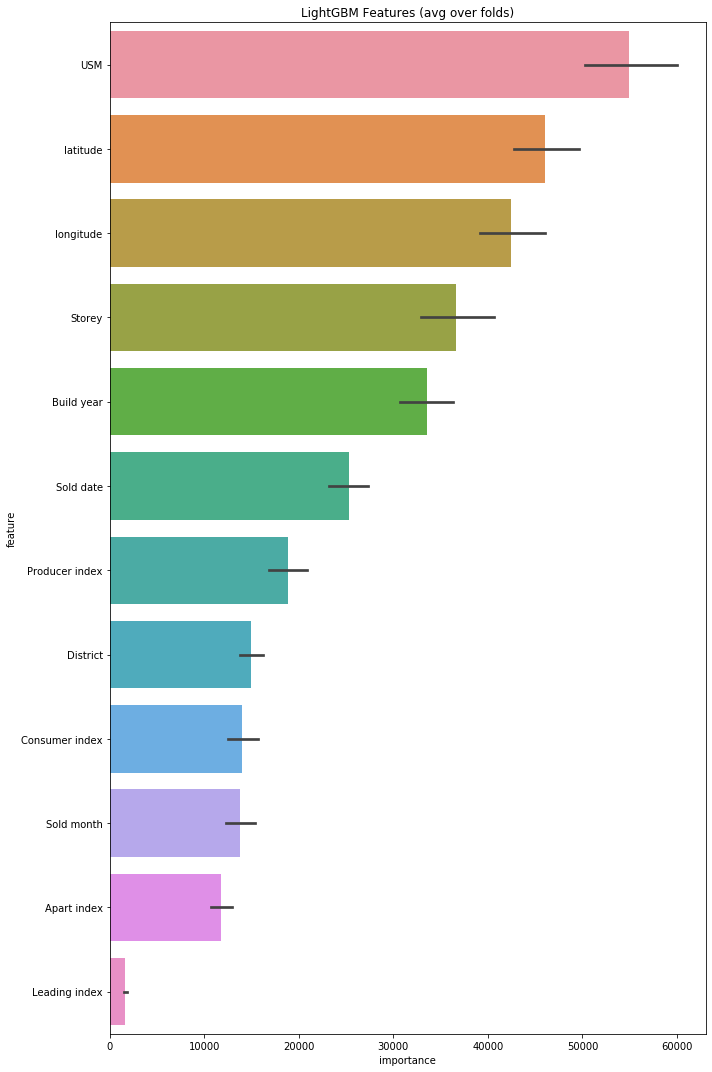

In [52]:
cols = (feature_importance_df[["feature", "importance"]].groupby("feature").mean()
        .sort_values(by="importance", ascending=False)[:20].index)
###각변수들 평규내서 위에서 상위 1000개뽑는것 근디 총변수가 180개인데 의미있나?
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
                ###900개중에서 해당하는 변수가 중복으로 뽑히게됨 결과로 보니 그런듯
    ###그런데 그림으로 그릴때는 이게 합쳐지는듯
plt.figure(figsize=(10,15))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances1.png')

In [53]:
(abs(testTarget-lightgbmPre)/testTarget*100).describe()

count    1393.000000
mean        4.137974
std         5.382100
min         0.000694
25%         1.302600
50%         2.857893
75%         5.307242
max        92.688563
dtype: float64

In [54]:
1-sum((testTarget-lightgbmPre)**2)/SST

0.9787594044081448

In [55]:
###lightgbm 데이터 다쓰는것 범주형 다쓰는거임
lightgbmOof2=np.zeros(len(kfoldData))
lightgbmPre2=np.zeros(len(kfoldTest))
folds=KFold(n_splits=5,shuffle=True,random_state=15)
feature_importance_df2 = pd.DataFrame()
features2=kfoldData.columns
for order, (train_idx,valid_idx) in enumerate(folds.split(kfoldData, kfoldTarget)):
    print('-')
    print("Fold {}".format(order + 1))
    trn_data = lgb.Dataset(kfoldData.iloc[train_idx], label=kfoldTarget.iloc[train_idx])
    val_data = lgb.Dataset(kfoldData.iloc[valid_idx], label=kfoldTarget.iloc[valid_idx])

    num_round = 10000          ###boosting 10000번 한다는소리임 verbose_eval 은 100번마다 출력함
    ###early는 100번동안 효과없으면 그만둠
    
    clf = lgb.train(param, trn_data, num_round, valid_sets = [val_data], verbose_eval=100, early_stopping_rounds=100)
    #훈련해서 모수가 조정된 모델에 valid 데이터 넣어서 예측값 보여주는것
    lightgbmOof2[valid_idx] = clf.predict(kfoldData.iloc[valid_idx], num_iteration=clf.best_iteration)
    ###5개모델 다더해서 나누면 최종 예측치 되는것
    lightgbmPre2 += clf.predict(kfoldTest, num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance_df2 = pd.DataFrame()
    fold_importance_df2["feature"]=features2
    fold_importance_df2["importance"] = clf.feature_importance()
    fold_importance_df2["order"] = order + 1
    
    feature_importance_df2 = pd.concat([feature_importance_df2, fold_importance_df2], axis=0)

-
Fold 1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 32.7741
[200]	valid_0's l1: 30.701
[300]	valid_0's l1: 29.6733
[400]	valid_0's l1: 29.1402
[500]	valid_0's l1: 28.7813
[600]	valid_0's l1: 28.482
[700]	valid_0's l1: 28.2699
[800]	valid_0's l1: 28.1123
[900]	valid_0's l1: 27.9397
[1000]	valid_0's l1: 27.7976
[1100]	valid_0's l1: 27.6952
[1200]	valid_0's l1: 27.6176
[1300]	valid_0's l1: 27.5626
[1400]	valid_0's l1: 27.484
[1500]	valid_0's l1: 27.4214
[1600]	valid_0's l1: 27.351
[1700]	valid_0's l1: 27.2987
[1800]	valid_0's l1: 27.25
[1900]	valid_0's l1: 27.1997
[2000]	valid_0's l1: 27.1495
[2100]	valid_0's l1: 27.0941
[2200]	valid_0's l1: 27.0592
[2300]	valid_0's l1: 27.0388
[2400]	valid_0's l1: 27.0016
[2500]	valid_0's l1: 26.9733
[2600]	valid_0's l1: 26.9591
[2700]	valid_0's l1: 26.9189
[2800]	valid_0's l1: 26.8861
[2900]	valid_0's l1: 26.8627
[3000]	valid_0's l1: 26.8426
[3100]	valid_0's l1: 26.8278
[3200]	valid_0's l1: 26.8159
[3300]	valid_0's

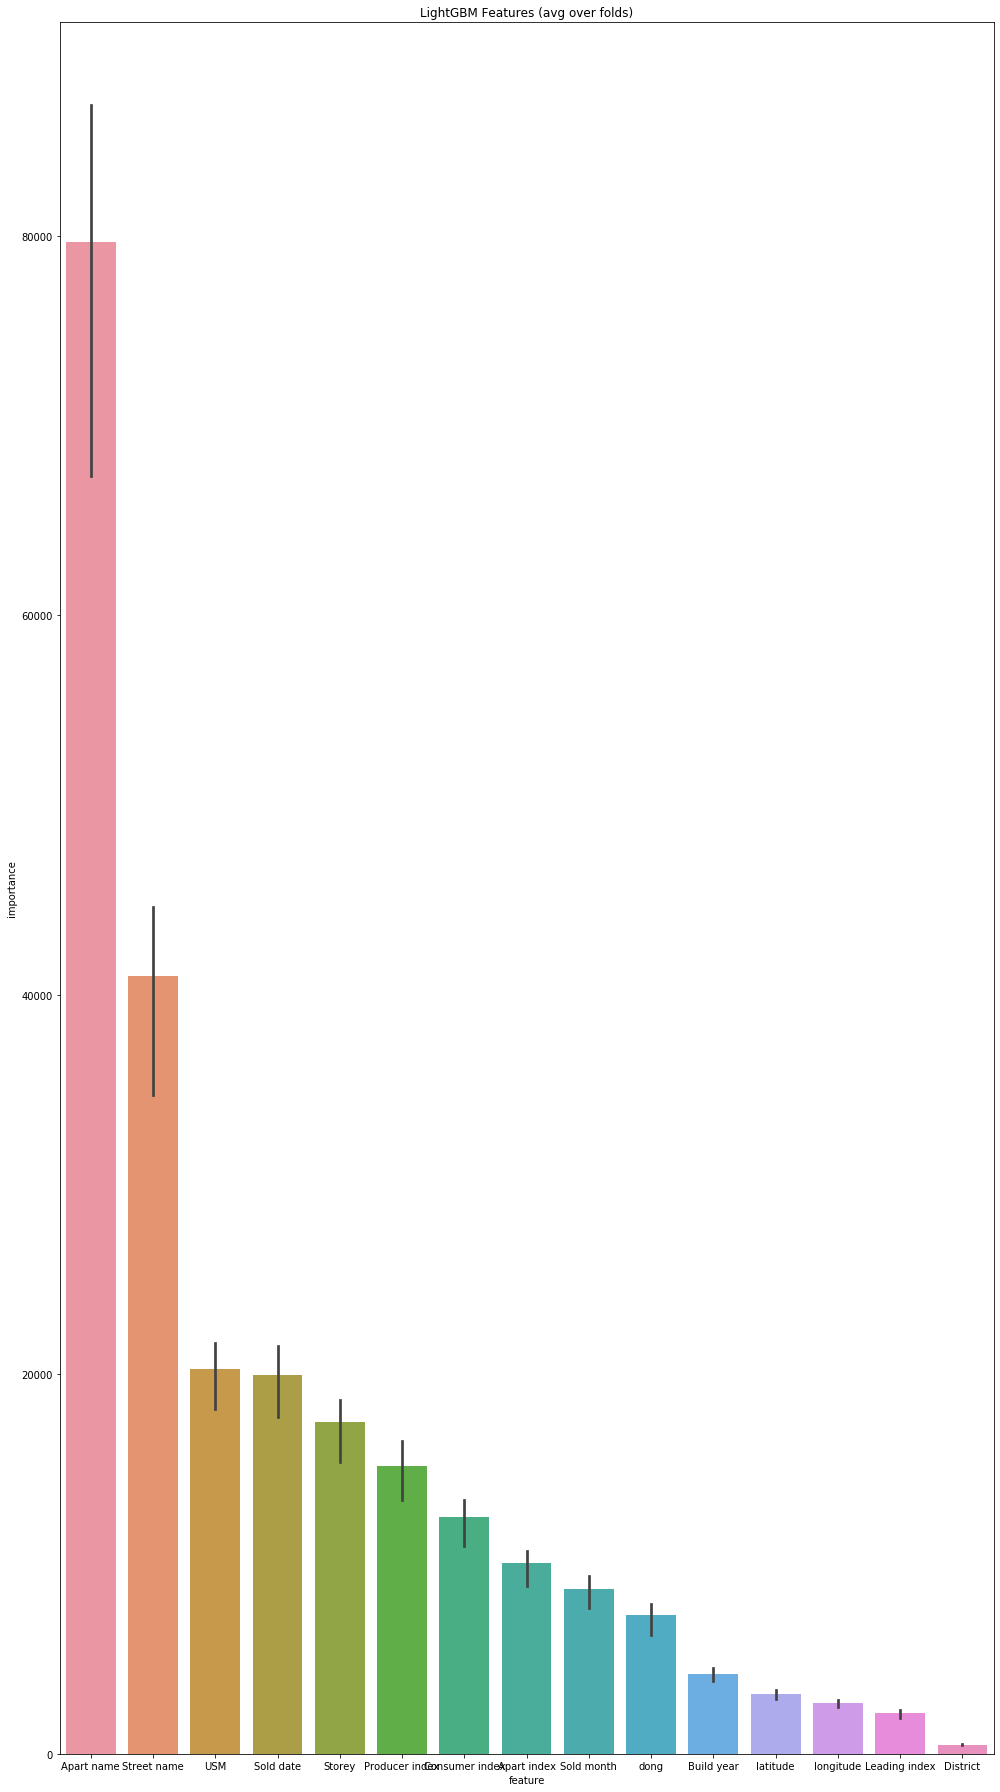

In [56]:
cols = (feature_importance_df2[["feature", "importance"]].groupby("feature").mean()
        .sort_values(by="importance", ascending=False)[:30].index)
###각변수들 평규내서 위에서 상위 1000개뽑는것 근디 총변수가 180개인데 의미있나?
best_features = feature_importance_df2.loc[feature_importance_df2.feature.isin(cols)]
                ###900개중에서 해당하는 변수가 중복으로 뽑히게됨 결과로 보니 그런듯
    ###그런데 그림으로 그릴때는 이게 합쳐지는듯
plt.figure(figsize=(14,25))
sns.barplot(x="feature",
            y="importance",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [57]:
#lightgbm단일모델 범주형 다씀
(abs(testTarget-lightgbmPre2)/testTarget*100).describe()

count    1393.000000
mean        3.945274
std         4.621221
min         0.015381
25%         1.302275
50%         2.867296
75%         5.089103
max        79.646925
dtype: float64

In [58]:
1-sum((testTarget-lightgbmPre2)**2)/SST

0.982335143413902